In [160]:
import pandas as pd
import re
import math
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from matplotlib.patches import Patch
plt.style.use('ggplot')

## Delta Crop Area Planted vs. Previous Year's Yield

In [446]:
crop_num = '15'

In [447]:
clean_cvfs = raw_cvfs.filter(regex='HHID|A10_(6[4-9]|7[0-2])|B'+crop_num+'[AB]_(6[4-9]|7[0-2])',axis=1)
    
# Separate information into different dataframes
total_area_cvfs = pd.DataFrame()
area_cvfs = pd.DataFrame()
production_cvfs = pd.DataFrame()

total_area_cvfs['HHID'] = clean_cvfs['HHID'] # Total area owned by household
area_cvfs['HHID'] = clean_cvfs['HHID'] # Area dedicated to a given crop
production_cvfs['HHID'] = clean_cvfs['HHID'] # Production of given crop
for year in range(64,73):
    total_area_cvfs[year] = clean_cvfs['A10_'+str(year)].astype(float)
    area_cvfs[year] = clean_cvfs.filter(regex='B'+crop_num+'A_'+str(year),axis=1).astype(float)
    production_cvfs[year] = clean_cvfs.filter(regex='B'+crop_num+'B_'+str(year),axis=1).astype(float)

delta_area_cvfs = area_cvfs.copy()
for year in range(65,73):
    delta_area_cvfs[year] = area_cvfs[year] - area_cvfs[year-1]
    
# Transform from wide to long
tarea_long_cvfs = pd.melt(total_area_cvfs, id_vars=['HHID'],var_name='Year',value_name='Total Area')
area_long_cvfs = pd.melt(area_cvfs, id_vars=['HHID'],var_name='Year',value_name='Area')
darea_long_cvfs = pd.melt(delta_area_cvfs, id_vars=['HHID'],var_name='Year',value_name='Delta Area')
production_long_cvfs = pd.melt(production_cvfs, id_vars=['HHID'],var_name='Year',value_name='Production')

# Normalize yield by area
production_long_cvfs['Production'] = production_long_cvfs['Production']/area_long_cvfs['Area']
production_long_cvfs['Production'].replace([math.nan,np.inf],0,inplace=True)

lag1_cvfs = pd.DataFrame()
lag1_cvfs['HHID'] = darea_long_cvfs[darea_long_cvfs['Year']>64]['HHID'].array
lag1_cvfs['Total Area'] = tarea_long_cvfs[tarea_long_cvfs['Year']>64]['Total Area'].array
lag1_cvfs['Delta Area'] = darea_long_cvfs[darea_long_cvfs['Year']>64]['Delta Area'].array
# Lag production data by one year
lag1_cvfs['Production_Lag_1'] = production_long_cvfs[production_long_cvfs['Year']<72]['Production'].array
lag1_cvfs = lag1_cvfs[lag1_cvfs['Production_Lag_1']>0]

In [455]:
raw_cvfs.filter(regex='HHID|B'+crop_num+'[AB]_(6[4-6])',axis=1)

,HHID,B15A_64,B15A_65,B15A_66,B15B_64,B15B_65,B15B_66
0,2002,.800000011921,.800000011921,.800000011921,23,21,20
1,2003,0,0,0,0,0,0
2,2004,2,2,2,40,50,30
3,2005,0,0,0,0,0,0
4,2006,0,0,0,0,0,0
...,...,...,...,...,...,...,...
2250,170052,0,0,0,0,0,0
2251,170061,0,0,0,0,0,0
2252,171002,0,0,0,0,0,0
2253,171003,2,2,2,29,29,28


Analyzing how yield from a previous year affects crop area planted in the following year

In [415]:
# Read raw data
raw_cvfs = pd.read_table('CVFS_Data_001.tsv')
raw_cvfs.replace(' ',0, inplace=True)

c:\users\kyan3\appdata\local\programs\python\python39\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (18,19,20,21,22,23,48,49,50,51,52,53,58,59,60,61,62,63,68,69,70,71,72,73,78,79,80,81,82,83,88,89,90,91,92,93,98,99,100,101,102,103,108,109,110,111,112,113,118,119,120,121,122,123,128,129,130,131,132,133,168,169,170,171,172,173,208,209,210,211,212,213,248,249,250,251,252,253,288,289,290,291,292,293,328,329,330,331,332,333,358,359,360,361,362,363,388,389,390,391,392,393,418,419,420,421,422,423,448,449,450,451,452,453,478,479,480,481,482,483,508,509,510,511,512,513,538,539,540,541,542,543,578,579,580,581,582,583,588,589,590,591,592,593,598,599,600,601,602,603,608,609,610,611,612,613,618,619,620,621,622,623,628,629,630,631,632,633,638,639,640,641,642,643,648,649,650,651,652,653,654,655,656,668,669,670,671,672,673,678,679,680,681,682,683,688,689,690,691,692,693,698,699,700,701,702,703,708,709,710,711,712,713,738,739,740,741,742,743,786) have mixed types.Specif

In [242]:
# Creates a plot of delta area vs. yield for a given crop
def delta_plot(raw_cvfs, crop_num, title, xlabel,ax):
    clean_cvfs = raw_cvfs.filter(regex='HHID|A10_(6[4-9]|7[0-2])|B'+crop_num+'[AB]_(6[4-9]|7[0-2])',axis=1)
    
    # Separate information into different dataframes
    total_area_cvfs = pd.DataFrame()
    area_cvfs = pd.DataFrame()
    production_cvfs = pd.DataFrame()
    
    total_area_cvfs['HHID'] = clean_cvfs['HHID'] # Total area owned by household
    area_cvfs['HHID'] = clean_cvfs['HHID'] # Area dedicated to a given crop
    production_cvfs['HHID'] = clean_cvfs['HHID'] # Production of given crop
    for year in range(64,73):
        total_area_cvfs[year] = clean_cvfs['A10_'+str(year)].astype(float)
        area_cvfs[year] = clean_cvfs.filter(regex='B'+crop_num+'A_'+str(year),axis=1).astype(float)
        production_cvfs[year] = clean_cvfs.filter(regex='B'+crop_num+'B_'+str(year),axis=1).astype(float)

    delta_area_cvfs = area_cvfs.copy()
    for year in range(65,73):
        delta_area_cvfs[year] = area_cvfs[year] - area_cvfs[year-1]

    # Transform from wide to long
    tarea_long_cvfs = pd.melt(total_area_cvfs, id_vars=['HHID'],var_name='Year',value_name='Total Area')
    area_long_cvfs = pd.melt(area_cvfs, id_vars=['HHID'],var_name='Year',value_name='Area')
    darea_long_cvfs = pd.melt(delta_area_cvfs, id_vars=['HHID'],var_name='Year',value_name='Delta Area')
    production_long_cvfs = pd.melt(production_cvfs, id_vars=['HHID'],var_name='Year',value_name='Production')
    
    # Normalize yield by area
    production_long_cvfs['Production'] = production_long_cvfs['Production']/area_long_cvfs['Area']
    production_long_cvfs['Production'].replace([math.nan,np.inf],0,inplace=True)

    lag1_cvfs = pd.DataFrame()
    lag1_cvfs['HHID'] = darea_long_cvfs[darea_long_cvfs['Year']>64]['HHID'].array
    lag1_cvfs['Total Area'] = tarea_long_cvfs[tarea_long_cvfs['Year']>64]['Total Area'].array
    lag1_cvfs['Delta Area'] = darea_long_cvfs[darea_long_cvfs['Year']>64]['Delta Area'].array
    # Lag production data by one year
    lag1_cvfs['Production_Lag_1'] = production_long_cvfs[production_long_cvfs['Year']<72]['Production'].array
    lag1_cvfs = lag1_cvfs[lag1_cvfs['Production_Lag_1']>0]
    
    # Threshold used to separate large household plots from small ones
    thres_total_area = 50
    large_lag1_cvfs = lag1_cvfs[lag1_cvfs['Total Area']>thres_total_area]
    small_lag1_cvfs = lag1_cvfs[lag1_cvfs['Total Area']<=thres_total_area]
    
    ax.axhline(0,color='red',zorder=0)
    ax.scatter(small_lag1_cvfs['Production_Lag_1'],small_lag1_cvfs['Delta Area'],color='coral')
    ax.scatter(large_lag1_cvfs['Production_Lag_1'],large_lag1_cvfs['Delta Area'],color='lightseagreen')
    ax.set_title(title,fontsize=20)
    ax.set_xlabel(xlabel,fontsize=16)
    ax.set_ylabel('$\Delta$ Planting area (katha)',fontsize=16)
    
    coral_patch =  Patch(facecolor='coral', edgecolor='coral', label='Total land $\leq$'+str(thres_total_area)+' katha')
    blue_patch = Patch(facecolor='lightseagreen', edgecolor='lightseagreen', label='Total land >'+str(thres_total_area)+' katha')
    ax.legend(handles=(coral_patch,blue_patch),loc=(0.45,0.1),facecolor='white')
    #ax.set_ylim([-100,100])

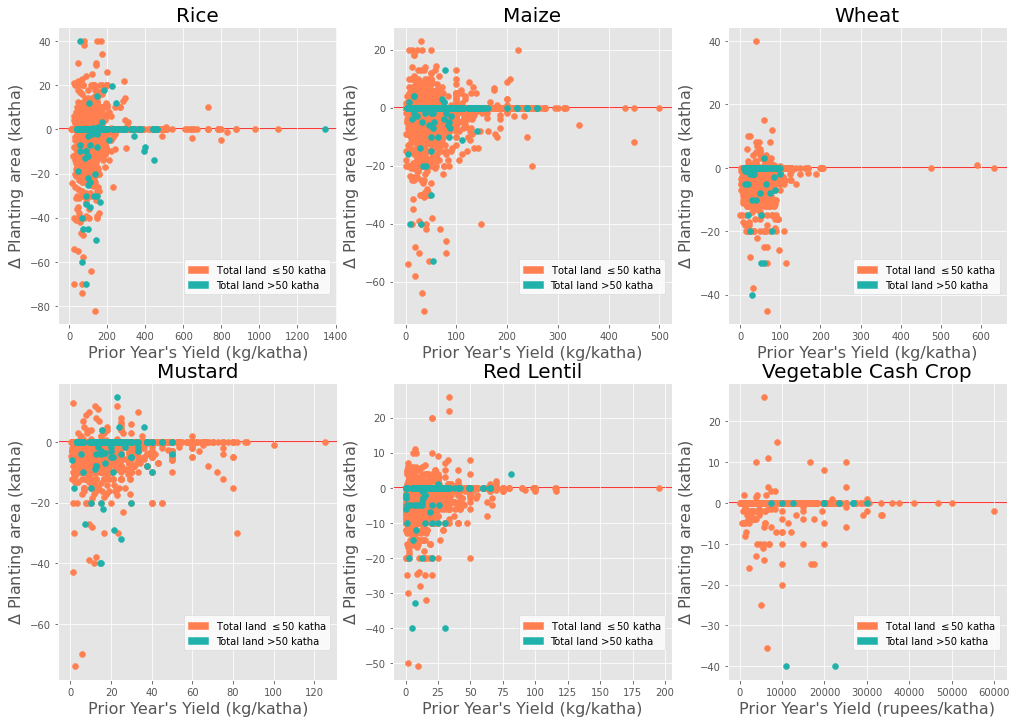

In [243]:
# Faceted plot with different crop types
cropnums = ['11','12','13','14','15','16']
cropnames = ['Rice','Maize','Wheat','Mustard','Red Lentil','Vegetable Cash Crop']

nrows = 2
ncols = 3
fig, axs = plt.subplots(nrows=nrows,ncols=ncols, figsize=(17,12))
for i in range(len(cropnums)):
    row = i/ncols
    col = i%ncols
    if cropnames[i] == 'Vegetable Cash Crop':
        xlabel = 'Prior Year\'s Yield (rupees/katha)'
    else:
        xlabel = 'Prior Year\'s Yield (kg/katha)'
    delta_plot(raw_cvfs,cropnums[i],title=cropnames[i],xlabel=xlabel,ax=axs[int(row)][col])

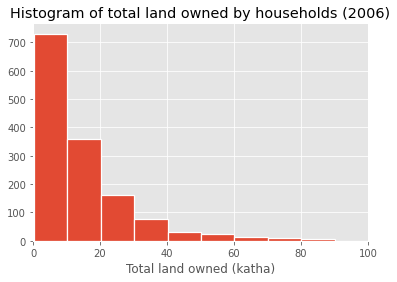

In [412]:
# Total land area data
land_cvfs = raw_cvfs.filter(regex='A10_64',axis=1).astype(float)
land_cvfs.replace([999,0],math.nan,inplace=True)

land_array = land_cvfs.values
land_array = land_array[~np.isnan(land_array)]

fig,ax = plt.subplots()
ax.hist(land_array,bins=20,edgecolor='white',linewidth=1.25);
ax.set_xlim((0,100));
ax.set_title('Histogram of total land owned by households (2006)');
ax.set_xlabel('Total land owned (katha)');

In [239]:
# To use as a threshold for large land holdings
np.quantile(land_array,0.95)

50.0

## Response to Community-Wide Yield in Previous Year

Instead of how a household responds to its own yield, look at how it might respond to the performance of that crop in the community as a whole

In [463]:
# Creates a plot of delta area vs. community yield for a given crop
def delta_plot_community(raw_cvfs, crop_num, title, xlabel,ax):
    clean_cvfs = raw_cvfs.filter(regex='HHID|A10_(6[4-9]|7[0-2])|B'+crop_num+'[AB]_(6[4-9]|7[0-2])',axis=1)

    # Separate information into different dataframes
    total_area_cvfs = pd.DataFrame() # Total area owned by household
    area_cvfs = pd.DataFrame() # Area dedicated to a given crop
    production_cvfs = pd.DataFrame() # Production of given crop

    total_area_cvfs['HHID'] = clean_cvfs['HHID'] 
    area_cvfs['HHID'] = clean_cvfs['HHID'] 
    production_cvfs['HHID'] = clean_cvfs['HHID'] 
    for year in range(64,73):
        total_area_cvfs[year] = clean_cvfs['A10_'+str(year)].astype(float)
        area_cvfs[year] = clean_cvfs.filter(regex='B'+crop_num+'A_'+str(year),axis=1).astype(float)
        production_cvfs[year] = clean_cvfs.filter(regex='B'+crop_num+'B_'+str(year),axis=1).astype(float)

    delta_area_cvfs = area_cvfs.copy()
    for year in range(65,73):
        delta_area_cvfs[year] = area_cvfs[year] - area_cvfs[year-1]

    # Transform from wide to long
    hh_area_long = pd.melt(total_area_cvfs, id_vars=['HHID'],var_name='Year',value_name='Total Area')
    delta_area_long = pd.melt(delta_area_cvfs, id_vars=['HHID'],var_name='Year',value_name='Delta Area')
    area_long = pd.melt(area_cvfs, id_vars=['HHID'],var_name='Year',value_name='Area')
    production_long = pd.melt(production_cvfs, id_vars=['HHID'],var_name='Year',value_name='Production')

    # Normalize production by area
    production_long['Production'] = production_long['Production']/area_long['Area']
    production_long['Production'].replace([math.nan,np.inf],0,inplace=True)

    # Create a data frame of community max production
    production_long = production_long[production_long['Production']>0]
    for i in range(64,73):
        production_cvfs[i] = production_long.pivot(index='HHID',columns='Year',values='Production').quantile(0.95,axis=0)[i]
    community_production_long = pd.melt(production_cvfs,id_vars=['HHID'],var_name='Year',value_name='Production')

    lag1_cvfs = pd.DataFrame()
    lag1_cvfs['HHID'] = delta_area_long[delta_area_long['Year']>64]['HHID'].array
    lag1_cvfs['HH Area'] = hh_area_long[hh_area_long['Year']>64]['Total Area'].array
    lag1_cvfs['Delta Area'] = delta_area_long[delta_area_long['Year']>64]['Delta Area'].array
    # Lag production data by one year
    lag1_cvfs['Production_Lag_1'] = community_production_long[community_production_long['Year']<72]['Production'].array
    lag1_cvfs = lag1_cvfs[lag1_cvfs['Production_Lag_1']>0]

    # Threshold used to separate large household plots from small ones
    thres_total_area = 50
    large_lag1_cvfs = lag1_cvfs[lag1_cvfs['HH Area']>thres_total_area]
    small_lag1_cvfs = lag1_cvfs[lag1_cvfs['HH Area']<=thres_total_area]

    ax.axhline(0,color='red',zorder=0)
    #small_lag1_cvfs.boxplot(column='Delta Area',by='Production_Lag_1',ax=ax)
    ax.scatter(small_lag1_cvfs['Production_Lag_1'],small_lag1_cvfs['Delta Area'],color='coral')
    ax.scatter(large_lag1_cvfs['Production_Lag_1'],large_lag1_cvfs['Delta Area'],color='lightseagreen')
    ax.set_title(title,fontsize=20)
    ax.set_xlabel(xlabel,fontsize=16)
    ax.set_ylabel('$\Delta$ Planting area (katha)',fontsize=16)

    coral_patch =  Patch(facecolor='coral', edgecolor='coral', label='Total land $\leq$'+str(thres_total_area)+' katha')
    blue_patch = Patch(facecolor='lightseagreen', edgecolor='lightseagreen', label='Total land >'+str(thres_total_area)+' katha')
    #ax.legend(handles=(coral_patch,blue_patch),loc=(0.45,0.1),facecolor='white')
    #ax.set_ylim([-100,100])

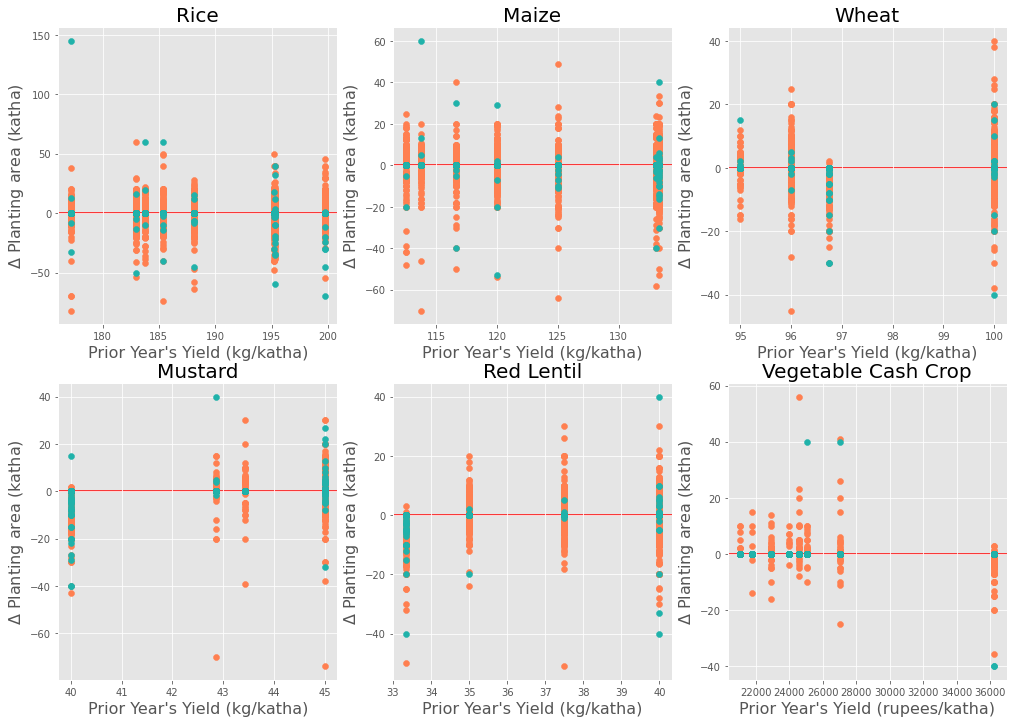

In [464]:
# Faceted plot with different crop types
cropnums = ['11','12','13','14','15','16']
cropnames = ['Rice','Maize','Wheat','Mustard','Red Lentil','Vegetable Cash Crop']

nrows = 2
ncols = 3
fig, axs = plt.subplots(nrows=nrows,ncols=ncols, figsize=(17,12))
for i in range(len(cropnums)):
    row = i/ncols
    col = i%ncols
    if cropnames[i] == 'Vegetable Cash Crop':
        xlabel = 'Prior Year\'s Yield (rupees/katha)'
    else:
        xlabel = 'Prior Year\'s Yield (kg/katha)'
    delta_plot_community(raw_cvfs,cropnums[i],title=cropnames[i],xlabel=xlabel,ax=axs[int(row)][col])

## Migrant Remittances

Analyzing relationship between multiple migrants and received remittances

In [41]:
raw_cvfs = pd.read_table('CVFS_Data_001.tsv')
raw_cvfs.replace(' ',0, inplace=True)
migrant_cvfs = raw_cvfs.filter(regex='HHID|MIG(6[4-9]|7[0-1])',axis=1).astype(float)
remit_cvfs = raw_cvfs.filter(regex='HHID|REM(6[4-9]|7[0-1])',axis=1).astype(float)

c:\users\kyan3\appdata\local\programs\python\python39\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (18,19,20,21,22,23,48,49,50,51,52,53,58,59,60,61,62,63,68,69,70,71,72,73,78,79,80,81,82,83,88,89,90,91,92,93,98,99,100,101,102,103,108,109,110,111,112,113,118,119,120,121,122,123,128,129,130,131,132,133,168,169,170,171,172,173,208,209,210,211,212,213,248,249,250,251,252,253,288,289,290,291,292,293,328,329,330,331,332,333,358,359,360,361,362,363,388,389,390,391,392,393,418,419,420,421,422,423,448,449,450,451,452,453,478,479,480,481,482,483,508,509,510,511,512,513,538,539,540,541,542,543,578,579,580,581,582,583,588,589,590,591,592,593,598,599,600,601,602,603,608,609,610,611,612,613,618,619,620,621,622,623,628,629,630,631,632,633,638,639,640,641,642,643,648,649,650,651,652,653,654,655,656,668,669,670,671,672,673,678,679,680,681,682,683,688,689,690,691,692,693,698,699,700,701,702,703,708,709,710,711,712,713,738,739,740,741,742,743,786) have mixed types.Specif

In [93]:
migrant_long = pd.melt(migrant_cvfs,id_vars=['HHID'],var_name='Year',value_name='Migrants')
remit_long = pd.melt(remit_cvfs,id_vars=['HHID'],var_name='Year',value_name='Remittances')

# Remove data points with zero migrants
remit_long = remit_long[migrant_long['Migrants']>0 ]
migrant_long = migrant_long[migrant_long['Migrants']>0]

# Remove data points with zero remittances
migrant_long = migrant_long[remit_long['Remittances']>0]
remit_long = remit_long[remit_long['Remittances']>0]

# Convert to USD
remit_long['Remittances'] = (remit_long['Remittances']*0.01)/2

In [100]:
n = int(migrant_long['Migrants'].max())
x = np.linspace(1,n,n)
averages = np.ones(n)
for i in range(1,n+1):
    averages[i-1] = remit_long[migrant_long['Migrants']==i]['Remittances'].mean()

In [121]:
migrant_long[migrant_long['Migrants']>0]

,HHID,Year,Migrants
17,2042.0,MIG64,1.0
30,3018.0,MIG64,1.0
67,7004.0,MIG64,2.0
108,11010.0,MIG64,3.0
139,13008.0,MIG64,1.0
...,...,...,...
18022,169039.0,MIG71,1.0
18024,170001.0,MIG71,4.0
18027,170004.0,MIG71,1.0
18029,170006.0,MIG71,3.0


(0.0, 20000.0)

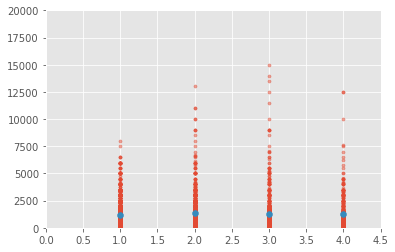

In [414]:
fig, ax = plt.subplots()
ax.scatter(migrant_long['Migrants'],remit_long['Remittances'],alpha=0.5,s=10)
ax.scatter(x,averages)
ax.set_xlim([0,4.5])
ax.set_ylim([0,20000])

## Aspiration Threshold Calculation

Calculating a baseline subsistence income, assuming that crops produced but not sold are used for household consumption and can be converted to a monetary value. 

In [140]:
raw_cvfs = pd.read_table('CVFS_Data_001.tsv')
raw_cvfs.replace(' ',0, inplace=True)
clean_cvfs = pd.DataFrame()
clean_cvfs['HHID'] = raw_cvfs['HHID']

# yield data for cereal crops (rice, maize, wheat); remove end years 63 and 72 due to inconsistency
p = re.compile('B1[1-3][bc]_(6[4-9]|7[0-1])', re.IGNORECASE)

for item in raw_cvfs.columns:    
    match = p.match(item)
    if bool(match):
        clean_cvfs[item] = raw_cvfs[item].astype(float)

# B indicates total crop yield; C indicates how much is sold
pivot_cvfs = pd.wide_to_long(clean_cvfs, ['B11B','B11C','B12B','B12C','B13B','B13C'], i='HHID', j='Year', sep='_')
pivot_cvfs

c:\users\kyan3\appdata\local\programs\python\python39\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (18,19,20,21,22,23,48,49,50,51,52,53,58,59,60,61,62,63,68,69,70,71,72,73,78,79,80,81,82,83,88,89,90,91,92,93,98,99,100,101,102,103,108,109,110,111,112,113,118,119,120,121,122,123,128,129,130,131,132,133,168,169,170,171,172,173,208,209,210,211,212,213,248,249,250,251,252,253,288,289,290,291,292,293,328,329,330,331,332,333,358,359,360,361,362,363,388,389,390,391,392,393,418,419,420,421,422,423,448,449,450,451,452,453,478,479,480,481,482,483,508,509,510,511,512,513,538,539,540,541,542,543,578,579,580,581,582,583,588,589,590,591,592,593,598,599,600,601,602,603,608,609,610,611,612,613,618,619,620,621,622,623,628,629,630,631,632,633,638,639,640,641,642,643,648,649,650,651,652,653,654,655,656,668,669,670,671,672,673,678,679,680,681,682,683,688,689,690,691,692,693,698,699,700,701,702,703,708,709,710,711,712,713,738,739,740,741,742,743,786) have mixed types.Specif

,,B11B,B11C,B12B,B12C,B13B,B13C
HHID,Year,,,,,,
2002,64,1220.0,0.0,360.0,0.0,0.0,0.0
2003,64,2684.0,1200.0,900.0,400.0,0.0,0.0
2004,64,1366.0,0.0,300.0,0.0,0.0,0.0
2005,64,488.0,0.0,120.0,0.0,0.0,0.0
2006,64,390.0,0.0,200.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
170052,71,1757.0,927.0,63.0,0.0,0.0,0.0
170061,71,1952.0,390.0,0.0,0.0,0.0,0.0
171002,71,1952.0,1500.0,2000.0,1500.0,0.0,0.0


In [141]:
# monetary equivalent of household consumption
rupees_produced = pd.DataFrame()
rupees_produced['Rice'] = (pivot_cvfs['B11B']-pivot_cvfs['B11C'])*24 #24 rupees/kg rice
rupees_produced['Maize'] = (pivot_cvfs['B12B']-pivot_cvfs['B12C'])*23 #23 rupees/kg maize
rupees_produced['Wheat'] = (pivot_cvfs['B13B']-pivot_cvfs['B13C'])*21 #21 rupees/kg wheat

rupees_produced

,,Rice,Maize,Wheat
HHID,Year,,,
2002,64,29280.0,8280.0,0.0
2003,64,35616.0,11500.0,0.0
2004,64,32784.0,6900.0,0.0
2005,64,11712.0,2760.0,0.0
2006,64,9360.0,4600.0,0.0
...,...,...,...,...
170052,71,19920.0,1449.0,0.0
170061,71,37488.0,0.0,0.0
171002,71,10848.0,11500.0,0.0


In [142]:
total_rupees = rupees_produced.mean(axis=0).sum()

(total_rupees*0.01)/2 #Nepalese rupee to USD conversion rate ~0.01

102.71197727272727